## Introduction to network-based analysis in biomedicine with python (Part 3)

#### Topic overview:

##### 1. Proximities in biological network

##### 2. Disease-disease relationship

##### 3. Drug repurposing

### Proximities in Network Medicine
<i>"Network Medicine combines principles and approaches from network sciences, systems biology, and human dynamics to understand the causes of human diseases and develop new treatments."</i>
(From <a href="https://www.network-medicine.org/" target="_blank">Network Medicine Institute and Global Alliance</a>)

Network-based proximities between nodes can be used for a wide-range of applications including identifying disease-disease relationships, drug efficacy screening, drug repurposing, and drug combination identification. Simply put, the distances between the nodes or groups of nodes representing disease genes or drug targets within a protein-protein interaction (PPI) network can be used to identify which two diseases are pathobiologically similar or if a drug already approved for one disease can be used for another disease. While distances between any two individual nodes in a network can be easily calulated as the shortest path between them, there might be different ways how we define distances or network proximity between groups of nodes. 

In this tutorial, we focus on a series of studies from <a href="https://www.barabasilab.com/" target="_blank">Barabasi-LAB</a> that utilized network-based proximities in network medicine. In their works, Barabasi's group has explored five different types of network-based proximity measures between genesets or modules within a PPI network. The different network-based proximity measures are explained below.

<img style="border:1px solid black;" src="Figures/Network_proximities_illustrations.png" alt="Network proximities" width=100%/>

<b>Figure:</b> Network-based proximity measures
Image from: <a href="https://doi.org/10.1038/ncomms10331" target="_blank">Network-based in silico drug efficacy screening</a>



For example, given ${P}$, the set of disease proteins, ${T}$, the set of drug targets and ${d(p,t)}$, the shortest path length between nodes ${p}$ and ${t}$ in the network, we define:

<b>Closest:</b> mean of the minimum distances of genes in ${T}$ to the genes in ${P}$. It considers the shortest path lengths from each target to the closest disease protein.

$$
\text{d}_{c}{(P,T)} =  \frac{1}{||T||}\sum_{t \in T}\min_{p \in P}\text{d(p,t)}
$$

<b>Shortest:</b> mean of the mean distances of genes in ${T}$ to all the genes in ${P}$. It averages over all shortest path lengths to the disease protein.

$$
\text{d}_{p}{(P,T)} = \frac{1}{||T||}\sum_{t \in T}\frac{1}{||P||}\sum_{p \in P}\text{d(p,t)}
$$

<b>Kernel:</b> a transformation that downweights longer paths using an exponential penalty.

$$
\text{d}_{k}{(P,T)} = \frac{-1}{||T||}\sum_{t \in T}\ln\sum_{p \in P}\frac{e^{-(d(p,t)+1)}}{|P|}
$$

<b>Centre:</b> mean of the distances of genes in ${T}$ to the topological centre of the genes in ${P}$. 

$$
\text{d}_{cc}{(P,T)} = \frac{1}{||T||}\text{d(centre}_{p}{,t)}
$$

where ${centre}_{P}$, the topological centre of ${P}$ was defined as:

$$
\text{centre}_{P} = {argmin}_{u \in P}\sum_{p \in P} {d(p, u)}
$$

in case the ${centre}_{P}$ is not unique, all the nodes are used to define the centre and the shortest path lengths to these nodes are averages.

Based on these proximity measures, they also recently introduced a network separation measure between two protein sets or modules. The network-based separation $S_{PT}$ can be quantified by comparing the mean shortest distances $\langle d_{PP} \rangle$ and $\langle d_{TT} \rangle$ within the respective sets of proteins, to the mean shortest distance $\langle d_{PT} \rangle$ between the two sets of proteins:

$$
\text{S}_{PT} \equiv \langle{d}_{PT}\rangle - \frac{\langle{d}_{PP}\rangle + \langle{d}_{TT}\rangle}{2}
$$

We explain this network-based separation measure and its application a little further down this tutorial.

While we define here the proximity measures between drug targets and disease proteins, the measures can be generalised for any two sets of proteins (or genes). Barabasi et al have used these measures with minor modifications for different tasks and have been defined within the respective papers.

<b>Further reading:</b>
- <a href="https://doi.org/10.1126/science.1257601" target="_blank">Uncovering disease-disease relationships through the incomplete interactome (2015)</a>
- <a href="https://doi.org/10.1038/ncomms10331" target="_blank">Network-based in silico drug efficacy screening (2016)</a>
- <a href="https://doi.org/10.1038/s41467-019-09186-x" target="_blank">Network-based prediction of drug combinations (2019)</a>
- <a href="https://doi.org/10.1073/pnas.2025581118" target="_blank">Network medicine framework for identifying drug-repurposing opportunities for COVID-19 (2021)</a>

#### Drug repurposing for COVID-19

Here, we demonstrate how we can use these network-based proximity measures for repurposing drugs for Covid-19, an infectious disease caused by the SARS-CoV-2 virus. The tutorial is based on the study <a href="https://doi.org/10.1073/pnas.2025581118" target="_blank"><em>Network medicine framework for identifying drug-repurposing opportunities for COVID-19</em></a> from Barabasi Lab.

Let us start by importing the necessary python modules.  

In [1]:
# Import Python modules
import networkx as nx
import numpy as np
import pandas as pd
import separation # from Barabasi-lab

In [2]:
# Import python modules for visualizations
import tqdm
import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

Here, the source code <em>separation.py</em> computes network-based separation between two input genesets. The separation.py file has been sourced from <a href="https://github.com/Barabasi-Lab/COVID-19/blob/main/utils/separation.py" target="_blank">GitHub</a>.

##### Human protein-protein interaction network
First, we upload known PPIs compiled from different annotation databases and then build a network with *NetworkX*

In [3]:
ppi = pd.read_csv("Data/Barabasi_CoV2_PPI.csv")
ppi.head()

,proteinA_entrezid,proteinB_entrezid,databases
0,9796,56992,bioplex|HIPPIE
1,7918,9240,instruct|hiunion|APID|biogrid|HINT-binary|intact
2,8233,23548,bioplex|HIPPIE
3,4899,11253,encode
4,5297,8601,bioplex


Now we create a graph object by using the python package NetworkX.

In [4]:
edges = zip(ppi.proteinA_entrezid, ppi.proteinB_entrezid)
ppi = nx.Graph()
ppi.add_edges_from(edges)

<p style="padding: 10px 10px 10px 10px; border: 2px solid red;">
<b>Box 3.1: Exercise</b><br>
How many connected components are there in the network? Extract the largest connected component.
</p>

In [5]:
# Extract the connected components 
graphs = (ppi.subgraph(c).copy() for c in nx.connected_components(ppi))

print("Number of connected components:", nx.number_connected_components(ppi))

# let's check the number of edges and node of each connected component
for g in graphs:
    if g.number_of_nodes() == 1: # skip the iteration if the connected component contains only one node
        continue
    else:
        print("--------------")
        print(g.number_of_nodes())
        print(g.number_of_edges())

Number of connected components: 56
--------------
18446
327868
--------------
3
2
--------------
2
1
--------------
2
1


In [6]:
# Select the largest connected component
G = list(ppi.subgraph(c).copy() for c in sorted(nx.connected_components(ppi), key = len, reverse = True))[0]
print(len(G.nodes()), len(G.edges()))

18446 327868


In [7]:
# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

##### SARS-CoV-2 targets in human
Let us now upload the known associations between SARS-CoV-2 proteins and human proteins. 

In [8]:
dt = pd.read_csv("Data/SARSCoV2_Targets.csv")
dt.head()

,SARS,EntrezID,Symbol
0,sars-cov2e,8546,AP3B1
1,sars-cov2e,23476,BRD4
2,sars-cov2e,6046,BRD2
3,sars-cov2e,10283,CWC27
4,sars-cov2e,124245,ZC3H18


Are all the human protein targets of the SARS-CoV-2 virus present in the interactome?

In [9]:
# check if the PPI includes all knonw SARS-CoV-2 targets
print(dt.shape)
print(len(set(G.nodes()).intersection(set(dt["EntrezID"]))))

(332, 3)
332


### Disease-disease relationship
The first objective of this NDM application is to study the association between COVID-19 and other diseases. Understanding disease-disease relationships can help in identifying pathobiological similarities between diseases and can aid in drug repurposing between similar diseases.

To this end we need to upload known disease-gene associations.

In [10]:
# Disease-gene associations were retrieved from OMIM and GWAS catalog using UniProtKB and PheGenI 
disease2genes = {}
for i in open("Data/Guney2016_GenesDisease.tsv").readlines():
    v = i.rstrip().split("\t")
    disease = v[1]
    genes = v[2:]
    if len(genes) > 19:
        disease2genes[disease] = [int(i) for i in genes]

# Total number of diseases
print(len(disease2genes)) 

299


In [11]:
diseasegenes = list(disease2genes.values())
diseasegenes = sum(diseasegenes, [])
diseasegenes = list(set(diseasegenes))
len(diseasegenes)

3173

<b>Network separation between the SARS-CoV-2 targets and known targets of other diseases</b>

<b>Network-based localization measures</b>

Network-based proximity is based on network-based localization measures. The figure below is an example of disease genes (red) that form one connected cluster of six genes, one cluster of two genes and one gene without connection to other disease genes. The size of the observable module is therefore given by S = 6. For three genes, A,B and C, the respective shortest distance to the next closest other disease gene is shown. 

<img src="Figures/Network_localization.png" alt="drawing" width="500">
<b>Figure:</b> Illustration of network based localization measure.
Image from <a href="https://doi.org/10.1126/science.1257601" target="_blank">Uncovering disease-disease relationships through the incomplete interactome</a>

<br>
<b>Network separation</b>

Network-based separation $S_{AB}$ between proteins of two diseases ${A}$ and ${B}$ can be quantified by comparing the mean shortest distances $\langle d_{AA} \rangle$ and $\langle d_{BB} \rangle$ within the respective diseases, to the mean shortest distance $\langle d_{AB} \rangle$ between the proteins of the two diseases. It is defined as:

$$
\text{S}_{AB} \equiv \langle{d}_{AB}\rangle - \frac{\langle{d}_{AA}\rangle + \langle{d}_{BB}\rangle}{2}
$$

The figure below shows the network-based separation measure for two diseases A (blue) and B (red) with one shared protein (“c”). The tables on the right give the values of the mean shortest distances within the diseases, $\langle d_{AA} \rangle$ and $\langle d_{BB} \rangle$, as well as the distances for all protein pairs between them, $\langle d_{AB} \rangle$. 

<img src="Figures/Network_based_separation.png" alt="drawing" width="700">
<b>Figure:</b> Illustration of network-based separation between two diseases.
Image from <a href="https://doi.org/10.1126/science.1257601" target="_blank">Uncovering disease-disease relationships through the incomplete interactome</a>


A positive $S_{AB}$ indicates that the two disease modules are separated on the interactome, whereas negative values correspond to overlapping modules.

Let us compute the overlap of proteins targeted by SARS-CoV-2 in human with genes associated with six diseases.

In [12]:
select_diseases = ["neurodegenerative diseases", "cardiovascular diseases", "peroxisomal disorders", "sarcoma", "psoriasis", "osteoporosis" ]
disease2genes = {key: disease2genes[key] for key in select_diseases}

# Print number of genes associated with each disease
for key in disease2genes.keys():
    print(key, len(disease2genes[key]))

neurodegenerative diseases 281
cardiovascular diseases 462
peroxisomal disorders 20
sarcoma 27
psoriasis 77
osteoporosis 23


In [13]:
# Calculate network-based separation 
sab = {}
for disease in tqdm.tqdm(disease2genes.keys()):
# for disease in tqdm.tqdm(list(disease2genes.keys())[0:5]):

    genes_A = set(dt.EntrezID) & set(G.nodes())
    genes_B = set(disease2genes[disease]) & set(G.nodes())
    d_A = separation.calc_single_set_distance(G,genes_A)
    d_B = separation.calc_single_set_distance(G,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(G,genes_A,genes_B)

    # calculate separation
    s_AB = d_AB - (d_A + d_B)/2.
    sab[disease] = s_AB

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:22<00:00,  3.67s/it]


In [14]:
dx = pd.DataFrame.from_dict(sab, orient='index')
dx = dx.reset_index()
dx.columns = ['disease', 'sab']
dx.sort_values(by = "sab", ascending = True).reset_index(drop = True)

,disease,sab
0,neurodegenerative diseases,0.034062
1,cardiovascular diseases,0.066427
2,osteoporosis,0.298515
3,psoriasis,0.306077
4,sarcoma,0.569504
5,peroxisomal disorders,0.826246


Here we can see that the genes associated with neurodegenerative diseases are the closest to the genes/proteins targeted by SARS-CoV-2 while genes associated with peroxisomal disorders are the farthest in the network. Further, since none of the diseases have negative $S_{AB}$ values, none of the diseases have genes overlapping with SARS-CoV-2 targets.

/tmp/ipykernel_1529414/2165318657.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dx['sab'],ax=ax)


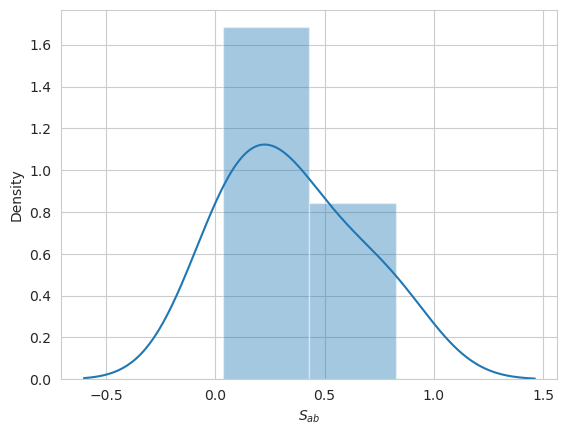

In [15]:
# Distribution of separation measure
fig, ax = plt.subplots(1,1)
sns.distplot(dx['sab'],ax=ax)
ax.set_xlabel('$S_{ab}$')
ax.set_ylabel('Density')
# fig.savefig('./Outputs/sab_virus_dist.png', dpi = 300)
plt.show()

### Drug repurposing
<b>Drug repurposing opportunities by crossing known SARS-CoV2 target (genes) with knonw drug-target associations</b>

Similar to using the network-based separation measure to study the overlap between the genes of two diseases, we can use it to understand the overlap between genes associated to diseases and known targets of drugs.

We measure the network proximity between drug–targets (A) and  SARS-CoV2-targets (B) as: 

$$
\text{S}_{AB} \equiv \langle{d}_{AB}\rangle - \frac{\langle{d}_{AA}\rangle + \langle{d}_{BB}\rangle}{2}
$$

For $S_{AB}$ < 0, the targets of the two drugs are located in the same network neighborhood, while for $S_{AB}$ ≥ 0, the two target sets are topologically separated. 

In [16]:
# Read known drug-gene associations
drug_gene_ixn = pd.read_csv("Data/drug2targets.csv")
drug_gene_ixn.head()

,Unnamed: 0,type,ID,Name,State,Approved,Indication,Gene_Target,DB_id,name,organism,Type,entrez_id,ATC_code
0,0,biotech,DB00001,Lepirudin,liquid,approved,For the treatment of heparin-induced thrombocy...,F2,BE0000048,Prothrombin,Humans,Polypeptide,2147.0,B01AE02
1,1,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",EGFR,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,1956.0,L01XC06
2,2,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",FCGR3B,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,2215.0,L01XC06
3,3,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",C1R,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,715.0,L01XC06
4,4,biotech,DB00002,Cetuximab,liquid,approved,"Cetuximab, used in combination with irinotecan...",C1QA,BE0002100,Low affinity immunoglobulin gamma Fc region re...,Humans,Polypeptide,712.0,L01XC06


Since our drug-gene assoication data contains withdrawn and illicit drugs as well, we filter them prior to further processing. We also remove any drugs that have no known status (marked as NaN).

In [17]:
drug_gene_ixn = drug_gene_ixn.loc[drug_gene_ixn['Approved'].isin(['approved', 'experimental', 'investigational', 'vet_approved'])]
drug_gene_ixn = drug_gene_ixn.dropna(subset = ['entrez_id'])
print("Number of drugs after filtering: ", len(drug_gene_ixn['Name'].unique()))

Number of drugs after filtering:  6057


<img src="Figures/Table1.png" alt="drawing" width="600"/>

In [18]:
print('Chloroquine' in set(drug_gene_ixn['Name']))
print('Vincristine' in set(drug_gene_ixn['Name']))
print('Doxazosin' in set(drug_gene_ixn['Name']))
print('Promazine' in set(drug_gene_ixn['Name']))
print('Ivermectin' in set(drug_gene_ixn['Name']))
print('Ulipristal' in set(drug_gene_ixn['Name']))

True
True
True
True
True
True


In [19]:
# Prepare known drug-target associations for a select list of drugs
drug2targets = {}
list_drugs_to_inv = ['Chloroquine', 'Vincristine','Doxazosin', 'Promazine', 'Ivermectin','Ulipristal']
for d in list_drugs_to_inv: 
    drug2targets[d] = [int(e) for e in drug_gene_ixn.loc[drug_gene_ixn['Name'] == d, 'entrez_id']]

In [20]:
# Print the number of known targets for each of the selected drugs
for key in drug2targets:
    print(key, len(drug2targets[key]))

Chloroquine 9
Vincristine 16
Doxazosin 12
Promazine 19
Ivermectin 9
Ulipristal 7


In [21]:
# Calculate the network-based separation of the drug targets from the proteins interacting with SARS-CoV-2
Drug_proximities = pd.DataFrame()

for drug in list_drugs_to_inv:

    genes_A = set(dt.EntrezID) & set(G.nodes())
    genes_B = set(drug2targets[drug]) & set(G.nodes())

    overlapping_genes = [[(set(genes_A) & set(genes_B))]]

    d_A = separation.calc_single_set_distance(G,genes_A)
    d_B = separation.calc_single_set_distance(G,genes_B)

    # distances BETWEEN the two gene sets:
    d_AB = separation.calc_set_pair_distances(G,genes_A,genes_B)

    # calculate separation
    s_AB = d_AB - (d_A + d_B)/2

    tmp = pd.DataFrame({"Drug" : drug,
                            "Number of targets in network" : len(genes_B),
                            "Separation" : s_AB,
                            "Overlaping genes" : overlapping_genes}, index = [0])
    Drug_proximities = pd.concat([Drug_proximities, tmp]).reset_index(drop = True)


Drug_proximities.sort_values(by = "Separation").reset_index(drop = True)

,Drug,Number of targets in network,Separation,Overlaping genes
0,Chloroquine,9,0.398146,[{}]
1,Ulipristal,7,0.399490,[{}]
2,Ivermectin,8,0.420898,[{4363}]
3,Vincristine,15,0.438388,[{4363}]
4,Doxazosin,12,0.600145,[{}]
5,Promazine,19,0.684113,[{}]


Here, we can see that the targets of Chloroquine had the least network topological separation from the SARS-CoV-2 targets signifying its potentential for the treatment of COVID-19. In fact, chloroquine was among the initial drugs that were approved for emergency use by FDA for treating COVID-19.

### Self-study material:
- <a href="https://doi.org/10.1093/bib/bbac229" target="_blank">Network approaches for modeling the effect of drugs and diseases</a>
